# Load some modules and the data

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import sklearn.metrics

## Load the data

In [408]:
data_file = "../DO_NOT_PUBLISH/MetaboData_pseudoID.xlsx"
metabol = pd.read_excel(data_file, sheet_name="metabs", index_col=0).T
# Min-max normalization
metabol.iloc[:,:] = MinMaxScaler().fit_transform(metabol)
metabol.head()

,glycine,alanine,valine,leucine,isoleucine,serine,threonine,proline,arginine,glutamic,...,tcc,m_bu_p,mehp,x4_hpb,ibp,cibp,apap,apap_g,dcf,hctz
S000178_1,0.203059,0.111499,0.191536,0.250043,0.257227,0.298541,0.066532,0.136444,0.188422,0.174716,...,0.0,0.271801,0.266637,0.161973,0.0,0.0,0.018271,0.028760,0.296658,0.0
S000443_1,0.073279,0.115869,0.132288,0.149303,0.148693,0.084232,0.022798,0.092352,0.025114,0.074864,...,0.0,0.221467,0.197153,0.129863,0.0,0.0,0.009566,0.010220,0.199715,0.0
S000491_1,0.212805,0.304089,0.249373,0.263820,0.277999,0.385945,0.242866,0.262947,0.085272,0.116247,...,0.0,0.431987,0.480285,0.612164,0.0,0.0,0.030228,0.060776,0.349946,0.0
S000732_1,0.136319,0.715659,0.582759,0.654555,0.671802,0.386421,0.549783,0.517717,0.404796,0.199605,...,0.0,0.168995,0.150266,0.189479,0.0,0.0,0.001626,0.004522,0.348757,0.0
S000732_2,0.178756,0.387277,0.334169,0.344584,0.369569,0.187183,0.546836,0.228796,0.201617,0.165235,...,0.0,0.123065,0.164727,0.188603,0.0,0.0,0.081787,0.212806,0.369097,0.0


In [409]:
samples = pd.read_excel(data_file, sheet_name="samples", index_col=0)

# Drop the observations cointaining missing values:
drop_index = samples[samples['CVrisk3'].isna()].index
metabol.drop(drop_index, inplace=True, errors="ignore")
# Subset only the indeces present in the metabol data set
samples = samples.loc[metabol.index,:]

# Code gender as 0, 1
samples['gender'] = samples['gender'] -1
# Code CVrisk3 as 0, 1, 2
samples['CVrisk3'] = pd.Categorical(samples['CVrisk3'], categories=('Low','Med','Hig')).codes
# Convert time_origin to categorical type
samples['time_origin'] = pd.Categorical(samples['time_origin'], categories=('baseline','six','twelve'))

samples.head()

,X.SampleID,KKHNGID,time_origin,gender,pred_risk,CVrisk3,AGE,SCBIA1,SCANT2,SCBIA4,TG,HDL,LDL,CHO,HBA1CPC,SCBP1,SCBP2,HSCRP,CR
S000178_1,S000178_1,20161,baseline,0,0.020379,2,51,22.52,90.0,10.15,1.13,1.68,4.94,6.87,5.1,125,90,0.71,77.0
S000443_1,S000443_1,3557,baseline,1,0.000580,0,41,23.06,96.8,33.33,1.30,1.68,2.78,4.29,5.5,113,78,0.32,63.0
S000491_1,S000491_1,1783,baseline,1,0.001671,1,47,22.15,92.3,30.20,0.90,1.46,2.80,4.69,5.3,117,82,0.78,65.0
S000732_1,S000732_1,104735,baseline,1,0.000308,0,38,22.90,87.6,30.42,1.38,1.94,1.56,3.54,5.2,109,83,2.86,70.0
S000732_2,S000732_2,104735,six,1,0.000398,0,39,23.34,102.5,31.41,1.10,1.86,1.65,3.82,4.9,117,83,2.13,78.0


In [410]:
print("Number of observations:", metabol.shape[0])
print("Number of variables:", metabol.shape[1])
print("Number of data points:", np.multiply(*metabol.shape))

Number of observations: 1020
Number of variables: 411
Number of data points: 419220


## Load the results

In [106]:
# Load the metrics
results_classic = pd.read_csv("results/metrics_classic.csv")
results_classic["Method"] = "Classic"
results_deepclust = pd.read_csv("results/metrics_deepclust.csv")
results_deepclust["Method"] = "Deep clustering"
results = pd.concat((results_classic, results_deepclust), axis=0)
results = results[['Method', 'rl_method', 'clust_method', 'n_clusters', 'variable', 'Acc', 'ARI', 'AMI', 'Sil', 'same_clust']]
results.columns = ('Method', 'FL method', 'CL method', 'num clusters', 'variable', 'Acc.', 'ARI.', 'AMI.', 'Sil.', 'Same clust.')

# Load the cluster assignments
assign_classic = pd.read_csv("results/assign_classic.csv")
assign_deepclust = pd.read_csv("results/assign_deepclust.csv")
assigns = pd.concat((assign_classic, assign_deepclust), axis=0)

# Summary of the results

## Summary of the metrics

In [6]:
results_mean = results.set_index(['Method', 'FL method', 'CL method']).groupby(level=[0,1,2]).mean()
results_mean = results_mean.iloc[:,1:]

metrics=['Acc.', 'ARI.', 'AMI.', 'Sil.', 'Same clust.']
results_mean.style.background_gradient(axis=0, cmap="cividis", text_color_threshold=0.3, subset=metrics).format('{:.2f}', subset=metrics)

In [7]:
results.index=np.arange(0,22)
results.style.background_gradient(axis=0, cmap="cividis", text_color_threshold=0.3, subset=metrics).format('{:.2f}', subset=metrics)

,Method,FL method,CL method,num clusters,variable,Acc.,ARI.,AMI.,Sil.,Same clust.
0,Classic,Raw data,K-Means,2,gender,0.55,0.00,0.00,0.25,0.47
1,Classic,Raw data,K-Means,3,cv_risk,0.36,0.00,0.00,0.09,0.21
2,Classic,Raw data,GMM,2,gender,0.55,0.00,0.00,0.17,0.33
3,Classic,Raw data,GMM,3,cv_risk,0.36,0.00,-0.00,0.10,0.17
4,Classic,Raw data,Agglo.,2,gender,0.55,0.00,0.00,0.24,0.46
5,Classic,Raw data,Agglo.,3,cv_risk,0.36,-0.00,0.00,0.11,0.18
6,Classic,PCA,K-Means,2,gender,0.55,0.00,0.00,0.29,0.47
7,Classic,PCA,K-Means,3,cv_risk,0.36,0.00,0.00,0.12,0.20
8,Classic,PCA,GMM,2,gender,0.55,0.01,0.01,0.14,0.24
9,Classic,PCA,GMM,3,cv_risk,0.37,0.00,0.00,0.02,0.12


In [8]:
# Markdown-like table:
# !pip install tabulate
# from tabulate import tabulate
# print(tabulate(results_mean.reset_index().round(2), headers='keys', tablefmt='pipe', showindex=False))

### Top results for Accuracy:

In [9]:
results.sort_values(by="Acc.", ascending=False).head(10).style.format('{:.2f}', subset=metrics)

,Method,FL method,CL method,num clusters,variable,Acc.,ARI.,AMI.,Sil.,Same clust.
14,Classic,FeatSel + PCA,GMM,2,gender,0.55,0.01,0.01,0.16,0.25
8,Classic,PCA,GMM,2,gender,0.55,0.01,0.01,0.14,0.24
0,Classic,Raw data,K-Means,2,gender,0.55,0.00,0.00,0.25,0.47
12,Classic,FeatSel + PCA,K-Means,2,gender,0.55,0.00,0.00,0.32,0.48
2,Classic,Raw data,GMM,2,gender,0.55,0.00,0.00,0.17,0.33
20,Deep clustering,VaDE,GMM,2,gender,0.55,0.00,0.00,0.57,0.30
4,Classic,Raw data,Agglo.,2,gender,0.55,0.00,0.00,0.24,0.46
18,Deep clustering,DEC,K-Means,2,gender,0.55,0.00,0.00,0.96,0.35
6,Classic,PCA,K-Means,2,gender,0.55,0.00,0.00,0.29,0.47
16,Classic,FeatSel + PCA,Agglo.,2,gender,0.55,0.00,0.00,0.28,0.41


In [10]:
# Markdown-like table:
# print(tabulate(results.sort_values(by="Acc.", ascending=False).head(10).round(2), headers='keys', tablefmt='pipe', showindex=False))

### Top results for Silhouette:

In [11]:
results.sort_values(by="Sil.", ascending=False).head(10).style.format('{:.2f}', subset=metrics)

,Method,FL method,CL method,num clusters,variable,Acc.,ARI.,AMI.,Sil.,Same clust.
18,Deep clustering,DEC,K-Means,2,gender,0.55,0.00,0.00,0.96,0.35
19,Deep clustering,DEC,K-Means,3,cv_risk,0.36,0.00,0.00,0.93,0.15
20,Deep clustering,VaDE,GMM,2,gender,0.55,0.00,0.00,0.57,0.30
21,Deep clustering,VaDE,GMM,3,cv_risk,0.36,0.00,0.00,0.45,0.20
10,Classic,PCA,Agglo.,2,gender,0.55,0.00,0.00,0.38,0.75
12,Classic,FeatSel + PCA,K-Means,2,gender,0.55,0.00,0.00,0.32,0.48
6,Classic,PCA,K-Means,2,gender,0.55,0.00,0.00,0.29,0.47
16,Classic,FeatSel + PCA,Agglo.,2,gender,0.55,0.00,0.00,0.28,0.41
0,Classic,Raw data,K-Means,2,gender,0.55,0.00,0.00,0.25,0.47
4,Classic,Raw data,Agglo.,2,gender,0.55,0.00,0.00,0.24,0.46


In [12]:
# Markdown-like table:
# print(tabulate(results.sort_values(by="Sil.", ascending=False).head(10).round(2), headers='keys', tablefmt='pipe', showindex=False))

### Top results for Same cluster:

In [13]:
results.sort_values(by="Same clust.", ascending=False).head(10).style.format('{:.2f}', subset=metrics)

,Method,FL method,CL method,num clusters,variable,Acc.,ARI.,AMI.,Sil.,Same clust.
10,Classic,PCA,Agglo.,2,gender,0.55,0.00,0.00,0.38,0.75
12,Classic,FeatSel + PCA,K-Means,2,gender,0.55,0.00,0.00,0.32,0.48
6,Classic,PCA,K-Means,2,gender,0.55,0.00,0.00,0.29,0.47
0,Classic,Raw data,K-Means,2,gender,0.55,0.00,0.00,0.25,0.47
4,Classic,Raw data,Agglo.,2,gender,0.55,0.00,0.00,0.24,0.46
16,Classic,FeatSel + PCA,Agglo.,2,gender,0.55,0.00,0.00,0.28,0.41
17,Classic,FeatSel + PCA,Agglo.,3,cv_risk,0.36,-0.00,0.00,0.22,0.39
18,Deep clustering,DEC,K-Means,2,gender,0.55,0.00,0.00,0.96,0.35
2,Classic,Raw data,GMM,2,gender,0.55,0.00,0.00,0.17,0.33
20,Deep clustering,VaDE,GMM,2,gender,0.55,0.00,0.00,0.57,0.30


In [14]:
# Markdown-like table:
# print(tabulate(results.sort_values(by="Same clust.", ascending=False).head(10).round(2), headers='keys', tablefmt='pipe', showindex=False))

## Plots

### Metrics

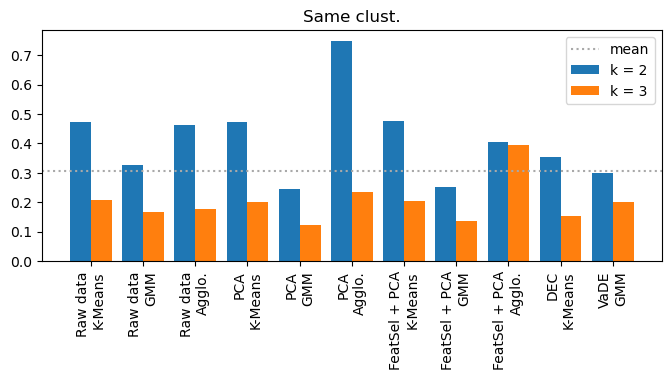

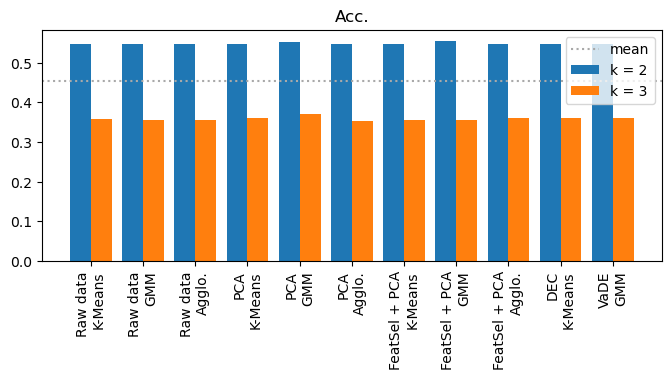

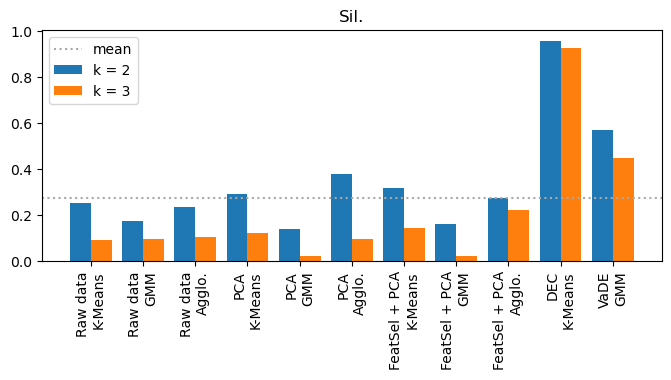

In [15]:
labels = (results['FL method'] + "\n" + results['CL method'])
color = ['red']*6 + ['green']*6 + ['blue']*6 + ['black']*4

for metric in (results['Same clust.'], results['Acc.'], results['Sil.']):
    plt.subplots(figsize=(8,3))
    plt.bar(labels[results['num clusters']==2], metric[results['num clusters']==2], label="k = 2", align='edge', width=-0.4)
    plt.bar(labels[results['num clusters']==3], metric[results['num clusters']==3], label="k = 3", align='edge', width=0.4)
    plt.axhline(y=metric.mean(), color='darkgray', ls='dotted', label="mean")
    plt.title(metric.name)
    plt.xticks(rotation=90, rotation_mode='anchor', ha='right', va='center')
    plt.legend()
    plt.show()

### Health indicators vs cluster assignments

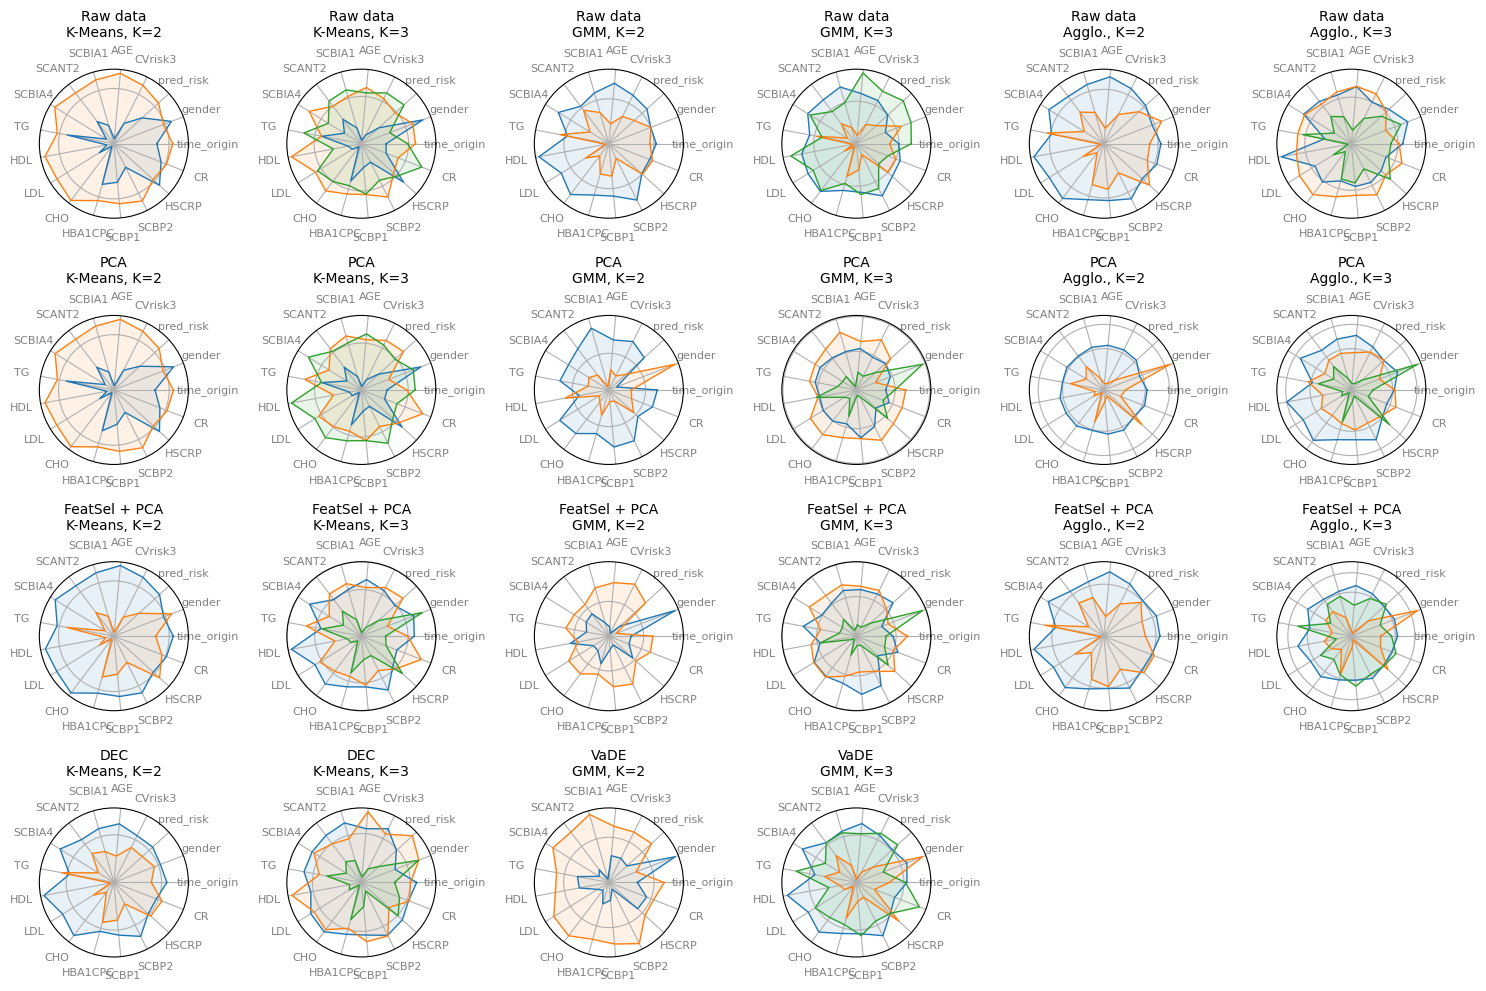

In [181]:
samples_ = samples.copy()
samples_.index = assigns.columns[3:]
samples_.time_origin = pd.Categorical(samples.time_origin, categories=('baseline','six','twelve')).codes
samples_.iloc[:,2:] = StandardScaler().fit_transform(samples_.iloc[:,2:])

plot_titles = list(assigns.rl_method + "\n" + assigns.clust_method)

categories = list(samples_.columns[2:])
N = len(categories)

angles = [n / N * 2 * np.pi for n in np.arange(N)]
angles += angles[:1]

fig, axs = plt.subplots(4, 6, figsize=(15,10), subplot_kw=dict(projection="polar"))
for i, ax in enumerate(axs.flatten()):
    if i >= len(plot_titles):
        ax.axis('off')
    else:
        ax.set_xticks(angles[:-1], categories, color='grey', size=8)
        ax.set_yticks(np.arange(0,1,0.2),[], color="grey", size=7)
        ax.set_title(f'{plot_titles[i]}, K={assigns.iloc[i,2]:d}', size=10)
        for k in range(assigns.iloc[i,2]):
            means = list(samples_.loc[assigns.iloc[i,3:]==k, "time_origin":].mean())
            means += means[:1]
            ax.plot(angles, means, linewidth=1, linestyle='solid')
            ax.fill(angles, means, alpha=0.1)
        
plt.tight_layout()
plt.show()

### Most variable features vs cluster assignments

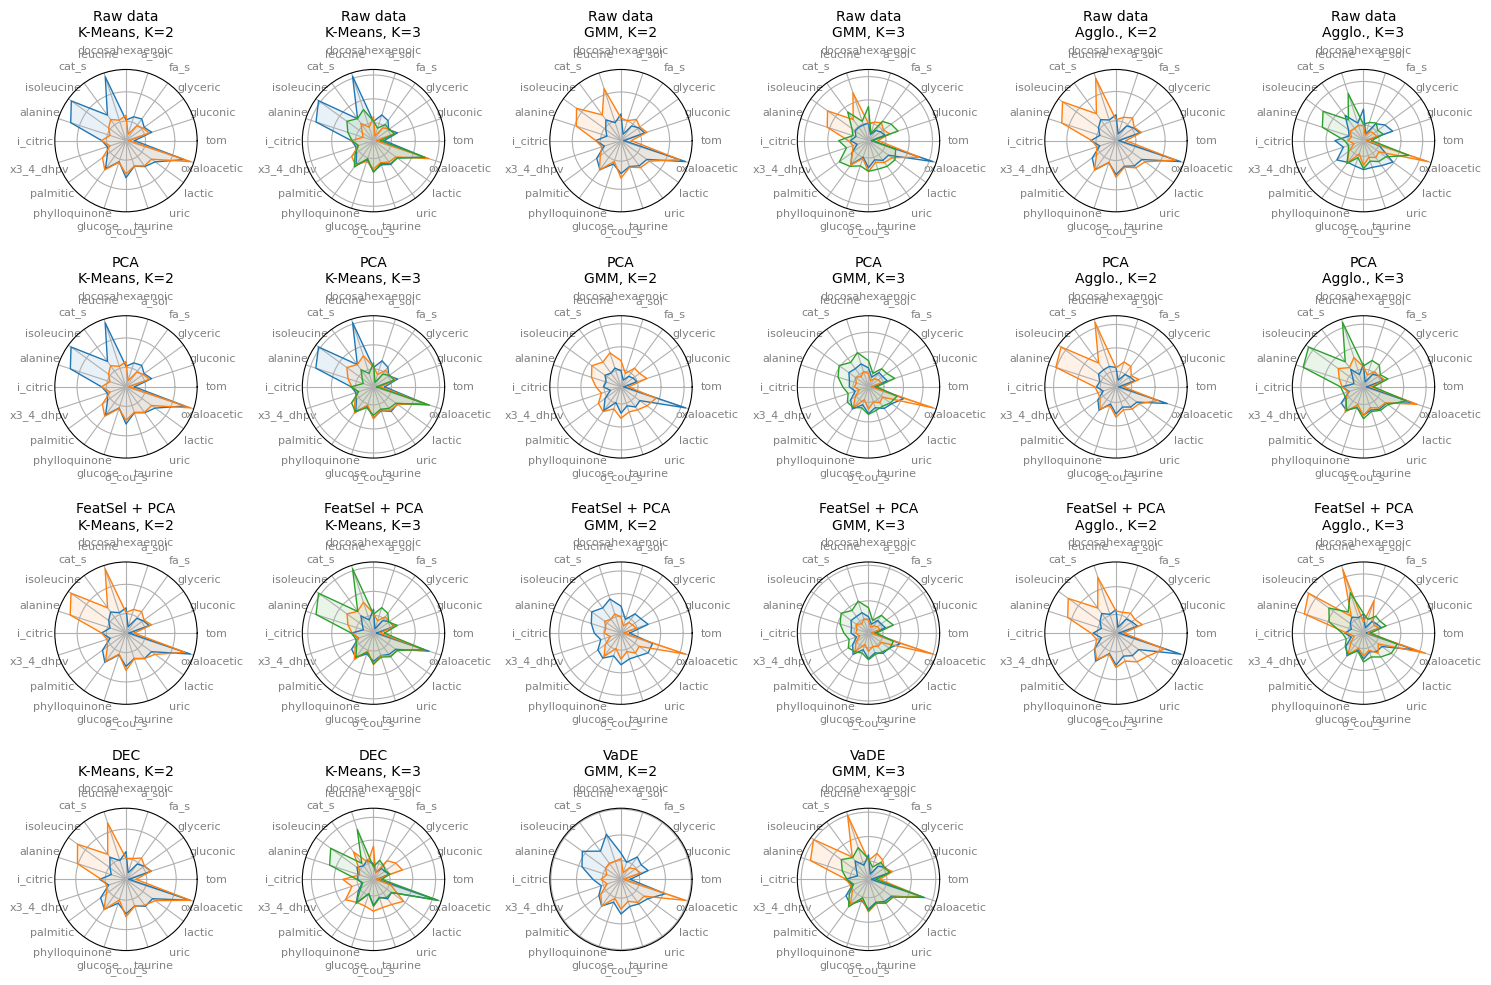

In [395]:
metabol_ = metabol.copy()
metabol_.index = assigns.columns[3:]
most_variable = metabol_.std().sort_values()[-20:].index

categories = most_variable
N = len(categories)
angles = [n / N * 2 * np.pi for n in np.arange(N)]
angles += angles[:1]

plot_titles = list(assigns.rl_method + "\n" + assigns.clust_method)

fig, axs = plt.subplots(4, 6, figsize=(15,10), subplot_kw=dict(projection="polar"))
for i, ax in enumerate(axs.flatten()):
    if i >= len(plot_titles):
        ax.axis('off')
    else:
        ax.set_xticks(angles[:-1], categories, color='grey', size=8)
        ax.set_yticks(np.arange(0,1,0.2),[], color="grey", size=7)
        ax.set_title(f'{plot_titles[i]}, K={assigns.iloc[i,2]:d}', size=10)
        for k in range(assigns.iloc[i,2]):
            means = list(metabol_.loc[assigns.iloc[i,3:]==k, most_variable].mean())
            means += means[:1]
            ax.plot(angles, means, linewidth=1, linestyle='solid')
            ax.fill(angles, means, alpha=0.1)
        
plt.tight_layout()
plt.show()

### Compare cluster assignments

,125,631,534,630,109,627,869,354,863,862,...,251,252,674,673,672,256,257,258,662,1019
Raw data - K-Means - K=2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,0,1,0
Raw data - GMM - K=2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,1,1,1,0,1
Raw data - Agglo. - K=2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,0
PCA - K-Means - K=2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,0,1,0
PCA - GMM - K=2,0,1,1,1,1,1,1,0,1,1,...,0,1,0,1,0,0,1,1,0,1
PCA - Agglo. - K=2,0,1,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
FeatSel + PCA - K-Means - K=2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,1
FeatSel + PCA - GMM - K=2,1,0,0,0,0,0,0,1,0,0,...,1,0,1,0,1,1,0,1,0,0
FeatSel + PCA - Agglo. - K=2,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,0,0,1,1,0,1
DEC - K-Means - K=2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,1,1,1,0,1


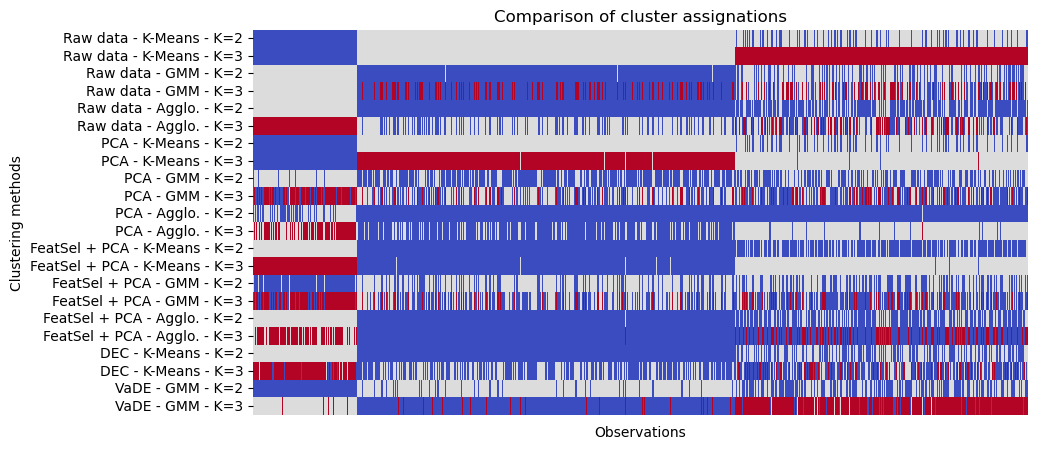

In [473]:
df = assigns.iloc[:,3:]
df.index = [" - ".join((*assigns.loc[i,'rl_method':'clust_method'], "K=" + assigns.loc[i,'n_clusters'].astype(str))) for i in assigns.index]
# df = df.loc[list(df.index[::2])+list(df.index[1::2]),:] # Group by K=2 / K=3
df = df.sort_values(by=df.index[1], axis=1)

plt.figure(figsize=(10,5))
sns.heatmap(df, annot=False, cmap="coolwarm", cbar=False)
plt.xticks([],[])
plt.xlabel("Observations")
plt.ylabel("Clustering methods")
plt.title("Comparison of cluster assignations")
plt.show()

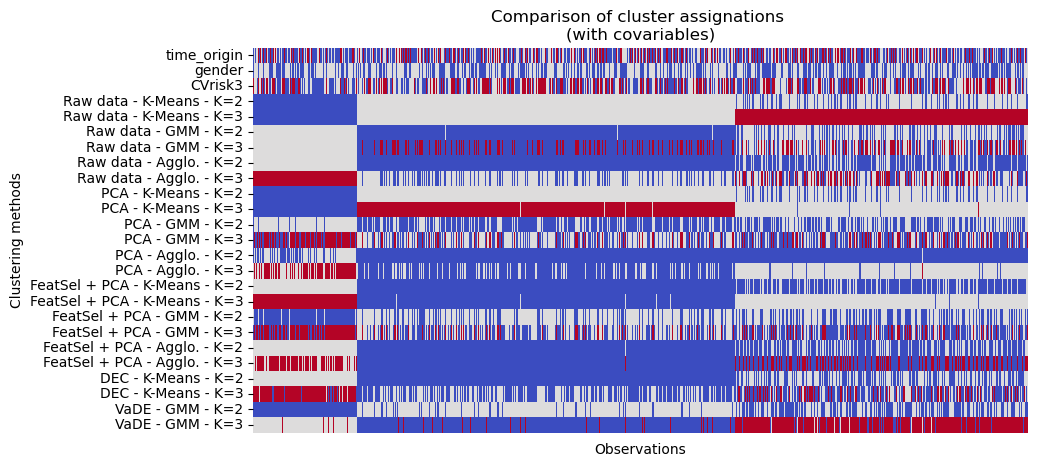

In [423]:
df = assigns.iloc[:,3:]
df.index = [" - ".join((*assigns.loc[i,'rl_method':'clust_method'], "K=" + assigns.loc[i,'n_clusters'].astype(str))) for i in assigns.index]
add = pd.DataFrame({"time_origin":pd.Categorical(samples.time_origin, categories=('baseline','six','twelve')).codes,
                   "gender": samples.gender,
                   "CVrisk3": samples.CVrisk3})
add.index = df.columns
df = pd.concat((add.T, df), axis=0)
df = df.sort_values(by=df.index[4], axis=1)

plt.figure(figsize=(10,5))
sns.heatmap(df, annot=False, cmap="coolwarm", cbar=False)
plt.xticks([],[])
plt.xlabel("Observations")
plt.ylabel("Clustering methods")
plt.title("Comparison of cluster assignations \n(with covariables)")
plt.show()

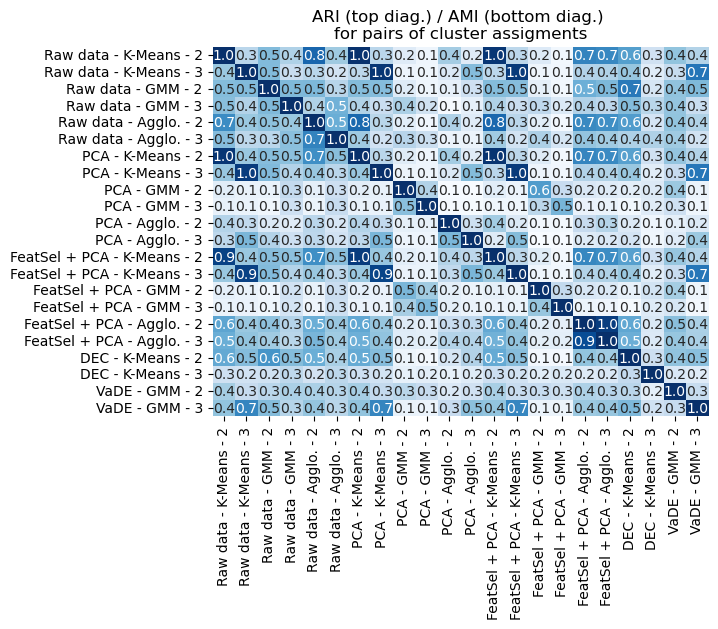

In [256]:
l = range(len(assigns.index))

ari = sklearn.metrics.adjusted_rand_score
ami = sklearn.metrics.adjusted_mutual_info_score

mat = pd.DataFrame([[ari(assigns.iloc[i,3:], assigns.iloc[j,3:]) if i > j else ami(assigns.iloc[i,3:], assigns.iloc[j,3:]) for i in l] for j in l])
mat.index = mat.columns = [" - ".join(assigns.iloc[i,0:3].astype(str)) for i in l]

sns.heatmap(mat, annot=True, fmt=".1f", cmap="Blues", cbar=False)
plt.title("ARI (top diag.) / AMI (bottom diag.) \nfor pairs of cluster assigments")
plt.show()

## Discussion

When comparing the assignments I find that while there is some agreement between some classic clustering methods, in general there is low overlapping.
The methods based on K-means tend to agree with themselfs, and in some cases with the agglomertive method.
The deep clustering methods show almost no overlap between themselfs or the other methods.


For the external metrics evaluated (accuracy, AMI, ARI), none of the clustering methods achieve a good score. There seems to be no relation between the found clusters and the health indicators I evaluated.

In the other hand, the radial plots of the health indicators suggest we did find some latent structure on the data. There indicitaors seem to have a differential multivariate distribution for the found clusters.


For the "Same cluster" metric, only one method (PCA + Agglo., K=2) achieved a good score, but it seems to be caused by the assignation of the majority of the observations to the same group. It doesn't seem that any algorithm assigned the different observations of the same individual to only one cluster.


Finally, for the internal metrics 8silhouette), only the DEC model stands out from the rest, achieving a relatively high score. This makes sense, since the loss function used to train this model favors a tight distribution the clusters.